In [1]:
import attack as att
import atmosphere as atmo
import aerodynamics as aero
import path
import rocket_parser as rp
import matplotlib.pyplot as plt
import math
import constants
import csv
import os

In [3]:
def write_arrays_to_csv(filename, **arrays):
    if not arrays:
        raise ValueError("Array is required.")
    
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    
    headers = list(arrays.keys())
    max_length = min(len(arr) for arr in arrays.values())
    
    with open(filename, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(headers)
        for i in range(max_length):
            row = [arrays[name][i] for name in headers]
            writer.writerow(row)
    
    print(f"Data was moved to '{filename}'.")

In [4]:
attack_list = []
time_list = []
wind_list = []

In [5]:
parser = rp.rocket_parser(path.rocket_lib + "master_rocket.json")

In [6]:
class ballistics:
    def __init__(self, N, Y, vel, alt):
        self.N = N
        self.Y = Y
        self.vel = vel
        self.alt = alt
        
        self.G = aero.UnionStream()
        self.G.set_elnumber(parser.get_block_number())
        self.G.set_diameter(parser.get_diameters())
        self.G.set_length(parser.get_part_length())

        self.thrust = 0
        self.mass = 0
        self.attack = 0
        self.dencity = 0
        
        self.atm = atmo.atmosphere(self.alt)
        self.last_time = None

    def update_params(self, time):
        if self.last_time != time:
            self.thrust =  parser.get_thrust_from_time(time)
            self.mass   =  parser.get_mass_from_time(time)
            self.attack = parser.get_attack(self.vel, time)*math.pi/180
            self.G.calculate_CXY(self.vel, self.alt, self.attack)

            self.atm = atmo.atmosphere(self.alt)
            self.dencity = self.atm.get_density()
            self.wind = self.atm.get_wind()

            if self.alt > 90000:
                self.G.CX = 0
                self.G.CY = 0
                self.dencity = 0

            self.last_time = time

            #output
            attack_list.append(self.attack*180/math.pi)
            time_list.append(time)
            wind_list.append(self.wind)


    def delta_velocity(self, time):
        self.update_params(time)
        F_P = self.thrust * math.cos(self.attack)
        F_X = self.G.CX*self.dencity*parser.maximum_area*self.vel**2/2
        return (F_P - F_X)/self.mass - self.atm.get_AOG() * math.sin(self.Y)

    def delta_trajangle(self, time):
        self.update_params(time)
        F_P = self.thrust * math.sin(self.attack)
        F_Y = self.G.CY*self.dencity*parser.maximum_area*self.vel**2/2
        F_G = self.atm.get_AOG() * math.cos(self.Y) * (1 - self.vel**2 / (self.atm.get_AOG() * (constants.earth_radius + self.alt))) 
        return (F_P + F_Y)/(self.mass*self.vel) - F_G/self.vel
    
    def delta_polar(self, time):
        self.update_params(time)
        return (self.vel/(constants.earth_radius + self.alt))*math.cos(self.Y)
    
    def delta_altitude(self, time):
        self.update_params(time)
        return self.vel * math.sin(self.Y)

    def delta_longitude(self, time):
        self.update_params(time)
        return self.vel * math.cos(self.Y)

In [16]:
def system(t, vars):
    n, y, v, h, l = vars
    b = ballistics(n, y, v, h)
    return [
        b.delta_polar(t),
        b.delta_trajangle(t),
        b.delta_velocity(t),
        b.delta_altitude(t),
        b.delta_longitude(t)
    ]

In [17]:
from scipy.integrate import solve_ivp

ft = parser.get_full_time()
h = parser.interstep
t_span = (0, ft-1)
y0 = [0, math.pi/2, 0.1, 0.1, 0.1]

sol = solve_ivp(system, t_span, y0, method='RK45', max_step=h)
print("Max velocity: ", sol.y[2][-1])
print("Max altitude: ", sol.y[3][-1]/1000)
print("Max trajangle: ", sol.y[1][-1]*57.3)
print("Max attack: ", attack_list[-1])

write_arrays_to_csv("output/dynamic_coefs.csv",
                    time=time_list,
                    wind=wind_list)

Max velocity:  8192.431733148596
Max altitude:  202.53672685479492
Max trajangle:  2.4170000846629356
Max attack:  4.126006443894015
Data was moved to 'output/dynamic_coefs.csv'.


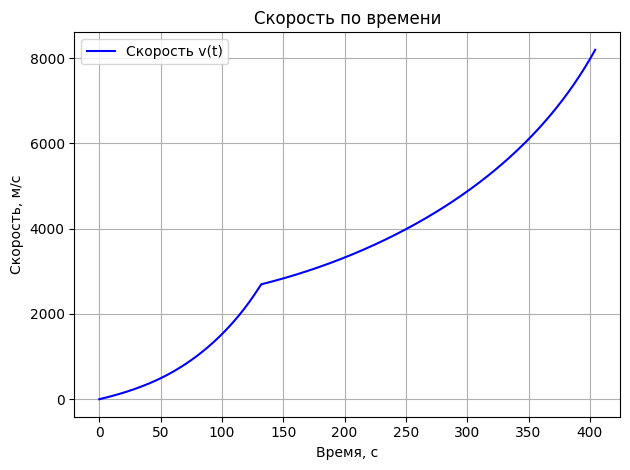

In [23]:
plt.plot(sol.t, sol.y[2], label='Скорость v(t)', color='blue')
plt.xlabel('Время, с')
plt.ylabel('Скорость, м/с')
plt.title('Скорость по времени')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

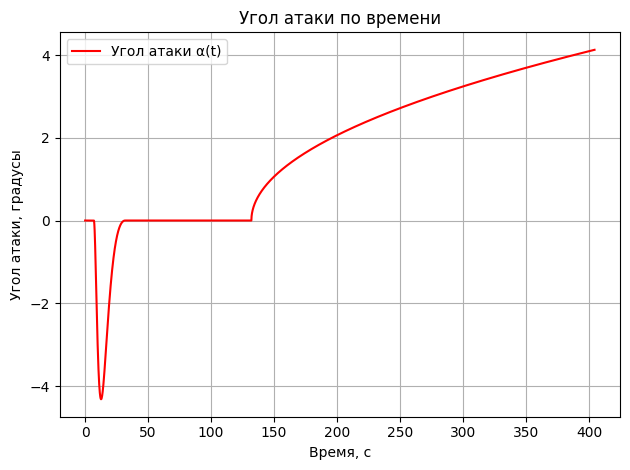

In [24]:
plt.plot(time_list, attack_list, label='Угол атаки α(t)', color='red')
plt.xlabel('Время, с')
plt.ylabel('Угол атаки, градусы')
plt.title('Угол атаки по времени')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

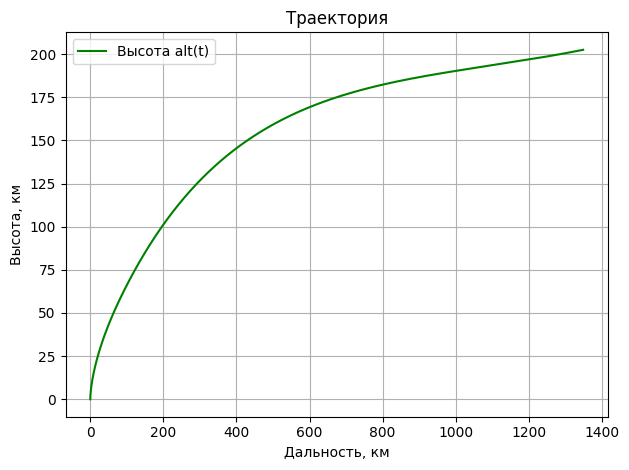

In [25]:
plt.plot(sol.y[4]/1000, sol.y[3]/1000, label='Высота alt(t)', color='green')
plt.xlabel('Дальность, км')
plt.ylabel('Высота, км')
plt.title('Траектория')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

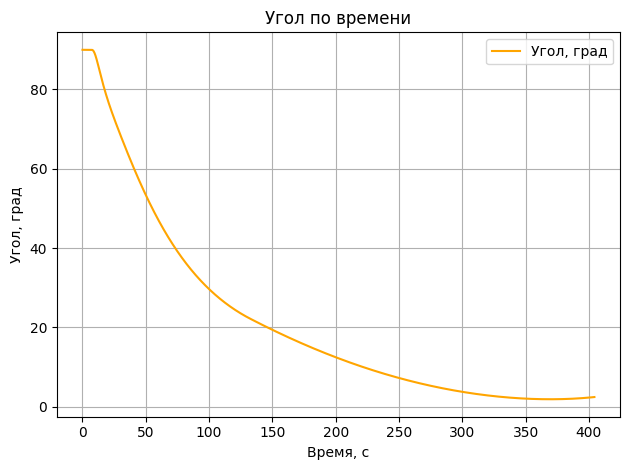

In [26]:
plt.plot(sol.t, sol.y[1]*57.3, label='Угол, град', color='orange')
plt.xlabel('Время, с')
plt.ylabel('Угол, град')
plt.title('Угол по времени')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()